# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [73]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 23, 49, 57, 421982)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
os.environ["HOPSWORKS_API_KEY"] = "5ZeL8lqjByt4B109.uQ5LcfxMaSKwSFxf8Pb2yUjMy89FhjVTD5DaHjV4gzMsYsZMbXSJdNV3JfRpoDmI"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1171606
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.235919E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='oscarej_featurestore')
fg = fs.get_feature_group('air_quality', version=1)

Connected. Call `.close()` to terminate connection gracefully.


In [9]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
last_three_days = air_quality_fg.read()
last_three_days = last_three_days.sort_values('date', ascending=False).head(3)
last_three_days = last_three_days.reset_index(drop=True)
print(last_three_days)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 
                       date  pm25  pm25_rolling_mean country           city  \
0 2024-11-19 00:00:00+00:00   1.0                NaN   japan  nishitokyoshi   
1 2024-11-13 00:00:00+00:00  36.0          41.666667   japan  nishitokyoshi   
2 2024-11-12 00:00:00+00:00  45.0          38.333333   japan  nishitokyoshi   

      street                               url  
0  Shimohoya  https://api.waqi.info/feed/@2430  
1  Shimohoya  https://api.waqi.info/feed/@2430  
2  Shimohoya  https://api.waqi.info/feed/@2430  
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,9.85,0.0,1.938659,291.801483,nishitokyoshi
1,2024-11-23 00:00:00+00:00,8.60,0.0,13.450708,344.475830,nishitokyoshi
2,2024-11-26 00:00:00+00:00,6.50,0.0,6.151683,339.443878,nishitokyoshi
3,2024-11-20 00:00:00+00:00,7.65,0.2,11.090103,346.865967,nishitokyoshi
4,2024-11-28 00:00:00+00:00,12.50,0.0,3.706427,240.945480,nishitokyoshi
5,2024-11-25 00:00:00+00:00,7.55,0.0,10.661107,348.310669,nishitokyoshi
6,2024-11-22 00:00:00+00:00,11.35,0.0,10.105681,355.914459,nishitokyoshi
7,2024-11-27 00:00:00+00:00,10.05,3.7,15.141414,341.995728,nishitokyoshi
8,2024-11-24 00:00:00+00:00,7.95,0.0,10.853866,5.710507,nishitokyoshi
9,2024-11-29 00:00:00+00:00,10.05,0.0,3.545589,246.037506,nishitokyoshi


Added code to update rolling means during prediction:

In [44]:
from collections import deque
import numpy as np

# Ensure the 'date' column is in datetime format
batch_data['date'] = pd.to_datetime(batch_data['date'])

# Sort batch_data by 'date' in ascending order
batch_data = batch_data.sort_values(by='date', ascending=True).reset_index(drop=True)

# Initialize rolling window with historical pm25 values
initial_values = last_three_days['pm25'].fillna(0).tolist()
rolling_window = deque(initial_values, maxlen=3)

# Prepare lists to store rolling means and predictions
pm25_rolling_means = []
predictions = []

# List of features required by the model
model_features = [
    'pm25_rolling_mean',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]

# Loop through batch_data to calculate rolling means and predict pm25
for _, row in batch_data.iterrows():
    # Calculate the rolling mean explicitly from the rolling window
    rolling_mean = np.mean(list(rolling_window))  # Accurate mean from the rolling window
    pm25_rolling_means.append(rolling_mean)
    
    # Prepare the input for the model
    feature_vector = [rolling_mean] + [row[feature] for feature in model_features[1:]]
    feature_vector = np.array(feature_vector).reshape(1, -1)  # Ensure correct shape
    
    # Predict pm25 using the feature vector
    prediction = retrieved_xgboost_model.predict(feature_vector)
    predictions.append(prediction[0])  # Extract scalar from prediction
    
    # Update the rolling window with the predicted pm25
    rolling_window.append(prediction[0])  # Add the new prediction to the rolling window

# Add the rolling mean and predictions to batch_data
batch_data['pm25_rolling_mean'] = pm25_rolling_means


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [45]:
"""batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['pm25_rolling_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data""" #Old code

batch_data['predicted_pm25'] = predictions

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean,predicted_pm25
0,2024-11-20 00:00:00+00:00,7.65,0.2,11.090103,346.865967,nishitokyoshi,27.333333,45.900600
1,2024-11-21 00:00:00+00:00,9.85,0.0,1.938659,291.801483,nishitokyoshi,42.300200,53.521694
2,2024-11-22 00:00:00+00:00,11.35,0.0,10.105681,355.914459,nishitokyoshi,48.140765,52.595791
3,2024-11-23 00:00:00+00:00,8.60,0.0,13.450708,344.475830,nishitokyoshi,50.672695,50.934795
4,2024-11-24 00:00:00+00:00,7.95,0.0,10.853866,5.710507,nishitokyoshi,52.350758,46.423878
5,2024-11-25 00:00:00+00:00,7.55,0.0,10.661107,348.310669,nishitokyoshi,49.984821,51.612751
6,2024-11-26 00:00:00+00:00,6.50,0.0,6.151683,339.443878,nishitokyoshi,49.657139,48.147102
7,2024-11-27 00:00:00+00:00,10.05,3.7,15.141414,341.995728,nishitokyoshi,48.727909,54.028790
8,2024-11-28 00:00:00+00:00,12.50,0.0,3.706427,240.945480,nishitokyoshi,51.262882,69.198944
9,2024-11-29 00:00:00+00:00,10.05,0.0,3.545589,246.037506,nishitokyoshi,57.124943,59.573879


In [46]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   pm25_rolling_mean            10 non-null     float64            
 7   predicted_pm25               10 non-null     float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 572.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [47]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,7.65,0.2,11.090103,346.865967,nishitokyoshi,27.333333,45.900600,Shimohoya,japan,1
1,2024-11-21 00:00:00+00:00,9.85,0.0,1.938659,291.801483,nishitokyoshi,42.300200,53.521694,Shimohoya,japan,2
2,2024-11-22 00:00:00+00:00,11.35,0.0,10.105681,355.914459,nishitokyoshi,48.140765,52.595791,Shimohoya,japan,3
3,2024-11-23 00:00:00+00:00,8.60,0.0,13.450708,344.475830,nishitokyoshi,50.672695,50.934795,Shimohoya,japan,4
4,2024-11-24 00:00:00+00:00,7.95,0.0,10.853866,5.710507,nishitokyoshi,52.350758,46.423878,Shimohoya,japan,5
5,2024-11-25 00:00:00+00:00,7.55,0.0,10.661107,348.310669,nishitokyoshi,49.984821,51.612751,Shimohoya,japan,6
6,2024-11-26 00:00:00+00:00,6.50,0.0,6.151683,339.443878,nishitokyoshi,49.657139,48.147102,Shimohoya,japan,7
7,2024-11-27 00:00:00+00:00,10.05,3.7,15.141414,341.995728,nishitokyoshi,48.727909,54.028790,Shimohoya,japan,8
8,2024-11-28 00:00:00+00:00,12.50,0.0,3.706427,240.945480,nishitokyoshi,51.262882,69.198944,Shimohoya,japan,9
9,2024-11-29 00:00:00+00:00,10.05,0.0,3.545589,246.037506,nishitokyoshi,57.124943,59.573879,Shimohoya,japan,10


In [48]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   pm25_rolling_mean            10 non-null     float64            
 7   predicted_pm25               10 non-null     float32            
 8   street                       10 non-null     object             
 9   country                      10 non-null     object             
 10  days_before_forecast_day     10 non-null     int64   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

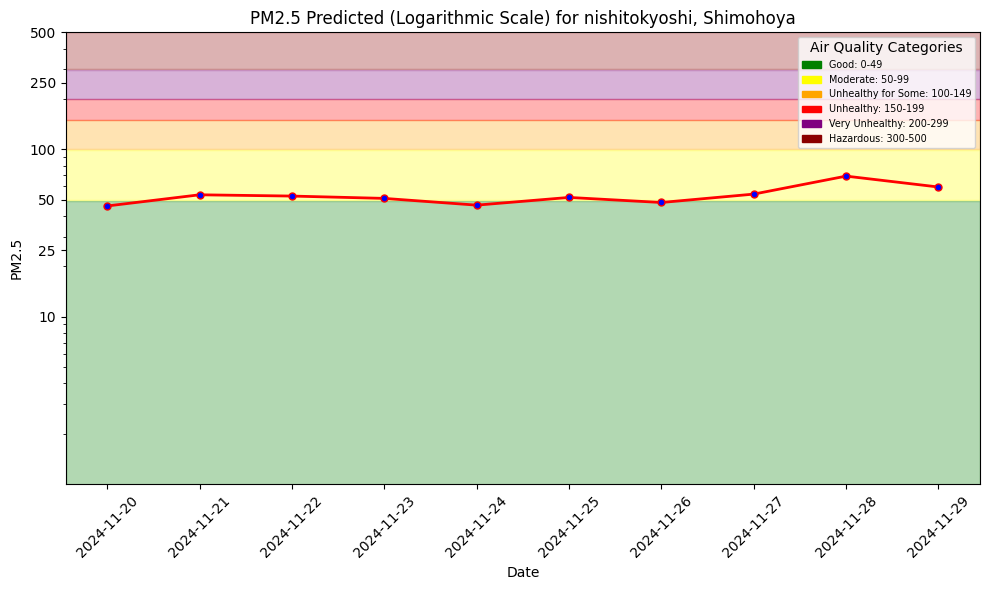

In [50]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [51]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [52]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1171606/fs/1162309/fg/1361227


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1171606/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x169d3d940>, None)

In [56]:
# Use Hive to read the data
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read(read_options={"use_hive": True})
monitoring_df

2024-11-20 11:34:01,835 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (1.02s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20,7.65,0.2,11.090103,346.86597,nishitokyoshi,27.333333,45.9006,Shimohoya,japan,1


In [60]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values(by='date', ascending=True).reset_index(drop=True)
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,date,pm25,pm25_rolling_mean,country,city,street,url
0,2014-01-01 00:00:00+00:00,69.0,26.333333,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
1,2014-01-02 00:00:00+00:00,36.0,41.333333,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
2,2014-01-03 00:00:00+00:00,56.0,47.000000,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
3,2014-01-04 00:00:00+00:00,42.0,53.666667,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
4,2014-01-05 00:00:00+00:00,22.0,44.666667,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
...,...,...,...,...,...,...,...
3922,2024-11-10 00:00:00+00:00,45.0,26.000000,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
3923,2024-11-11 00:00:00+00:00,35.0,34.666667,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
3924,2024-11-12 00:00:00+00:00,45.0,38.333333,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430
3925,2024-11-13 00:00:00+00:00,36.0,41.666667,japan,nishitokyoshi,Shimohoya,https://api.waqi.info/feed/@2430


In [122]:
weather_df = weather_fg.read()
weather_df = pd.merge(weather_df, air_quality_df[['date', 'pm25_rolling_mean']], on='date', how='left')
weather_df = weather_df.sort_values(by="date")

# Identify rows with missing pm25_rolling_mean after the merge
missing_rows = weather_df['pm25_rolling_mean'].isnull()

# Recalculate rolling mean for missing rows
if missing_rows.any():
    print(f"Found {missing_rows.sum()} rows with missing pm25_rolling_mean. Recalculating...")
    recalculated_mean = (
        air_quality_df['pm25']
        .shift(1)  # Exclude the current day
        .rolling(window=3, min_periods=1)  # Use a rolling window of 3
        .mean()
        .reindex(weather_df.index)  # Align indices with weather_df
    )
    # Assign recalculated values to missing rows
    weather_df.loc[missing_rows, 'pm25_rolling_mean'] = recalculated_mean[missing_rows]

# Check for remaining NaN values
remaining_nan = weather_df['pm25_rolling_mean'].isnull()
if remaining_nan.any():
    print(f"Still {remaining_nan.sum()} rows with missing pm25_rolling_mean. Filling using batch_data...")
    
    # Merge batch_data to align dates and use its pm25_rolling_mean values
    weather_df = pd.merge(
        weather_df,
        batch_data[['date', 'pm25_rolling_mean']].rename(columns={'pm25_rolling_mean': 'batch_pm25_rolling_mean'}),
        on='date',
        how='left'
    )
    
    # Fill remaining NaN values in pm25_rolling_mean with batch_pm25_rolling_mean
    weather_df['pm25_rolling_mean'] = weather_df['pm25_rolling_mean'].fillna(weather_df['batch_pm25_rolling_mean'])
    
    # Drop the auxiliary column after filling
    weather_df = weather_df.drop(columns=['batch_pm25_rolling_mean'])

# Verify recalculated rows
print("Final rows with recalculated pm25_rolling_mean:")
print(weather_df[missing_rows][['date', 'pm25_rolling_mean']])

# Drop rows with NaN in 'pm25_rolling_mean' (if absolutely necessary, should be redundant after filling)
weather_df = weather_df.dropna(subset=['pm25_rolling_mean'])

# Create or update the feature group
new_fg = fs.get_or_create_feature_group(
    name='weather_with_pm25',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city', 'date'],
    event_time="date"
)

# Insert the cleaned DataFrame
new_fg.insert(weather_df, write_options={"wait_for_job": True})

# Validate the insertion
inserted_data = new_fg.read(read_options={"use_hive": True})
print("Inserted data:")
print(inserted_data)
print("Null values in inserted data:")
print(inserted_data.isnull().sum())


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.06s) 
Found 59 rows with missing pm25_rolling_mean. Recalculating...
Still 10 rows with missing pm25_rolling_mean. Filling using batch_data...
Final rows with recalculated pm25_rolling_mean:
2024-11-20 15:57:51,956 WARNING: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

                          date  pm25_rolling_mean
68   2014-03-10 00:00:00+00:00          49.666667
179  2014-06-29 00:00:00+00:00          40.000000
209  2014-07-29 00:00:00+00:00          65.666667
325  2014-11-22 00:00:00+00:00          57.666667
439  2015-03-16 00:00:00+00:00          70.000000
524  2015-06-09 00:00:00+00:00          40.000000
604  2015-08-28 00:00:00+00:00          23.000000
652  2015-10-15 00:00:00+00:00          58.000000
775  2016-02-15 00:00:00+00:00          58.000000
786  2016-02-26 00:00:00+00:00          51.666667
1065 2016-12-01 00:00:00+00:00          34.000000
1137 2017-02-11 00:

Uploading Dataframe: 0.00% |          | Rows 0/3984 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_with_pm25_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1171606/jobs/named/weather_with_pm25_1_offline_fg_materialization/executions
2024-11-20 15:59:27,169 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (1.42s) 
Inserted data:
           date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0    2018-10-27            17.269250                4.5           16.311613   
1    2024-06-24            27.096338                0.3           19.191748   
2    2024-05-24            22.038000                0.0           34.322937   
3    2022-04-22            19.267166                0.0           15.003839   
4    2020-09-07            26.650503                5.3           44.168640   
...         ...                  ...                ...                 ...   
3979 2020-11-08            15.142166                0.0       

In [123]:
from numpy import float32

# Prepare DataFrames
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

# Convert the 'date' column in both DataFrames to datetime without timezone
outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)

# Merge predictions with outcomes
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If no outcomes for predictions, generate predictions and outcomes
if len(hindcast_df) == 0:
    # Read features from the new_fg feature group
    features_df = new_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True).tail(10)
    print(features_df.head())
    print(features_df.isnull().sum())  # Check for missing values
    print(features_df[['date', 'pm25_rolling_mean']].head())
    if 'pm25_rolling_mean' not in features_df.columns or features_df['pm25_rolling_mean'].isnull().all():
        print("pm25_rolling_mean is missing in new_fg.")


    # Predict pm25
    features_df['predicted_pm25'] = retrieved_xgboost_model.predict(
        features_df[['pm25_rolling_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )

    # Merge predictions with air_quality_df to create hindcast_df
    df = pd.merge(features_df, air_quality_df[['date', 'pm25', 'street', 'country']], on="date", how="left")
    df['days_before_forecast_day'] = 1

    # Fill missing values
    df['street'] = df['street'].fillna("Shimohoya")
    df['country'] = df['country'].fillna("japan")

    # Ensure data types match schema
    df['predicted_pm25'] = df['predicted_pm25'].astype(float32)
    hindcast_df = df

    # Insert monitoring data into monitor_fg
    monitoring_data = df.drop(columns=['pm25'])
    monitor_fg.insert(monitoring_data, write_options={"wait_for_job": True})

hindcast_df


2024-11-20 15:59:45,124 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-11-20 15:59:45,125 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 
                          date  temperature_2m_mean  precipitation_sum  \
2640 2024-11-20 00:00:00+00:00                 7.65                0.2   
3218 2024-11-21 00:00:00+00:00                 9.85                0.0   
2896 2024-11-22 00:00:00+00:00                11

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1171606/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,7.65,0.2,11.090103,346.865967,nishitokyoshi,27.333333,45.900600,NaN,Shimohoya,japan,1
1,2024-11-21 00:00:00+00:00,9.85,0.0,1.938659,291.801483,nishitokyoshi,42.300200,53.521694,NaN,Shimohoya,japan,1
2,2024-11-22 00:00:00+00:00,11.35,0.0,10.105681,355.914459,nishitokyoshi,48.140765,52.595791,NaN,Shimohoya,japan,1
3,2024-11-23 00:00:00+00:00,8.60,0.0,13.450708,344.475830,nishitokyoshi,50.672695,50.934795,NaN,Shimohoya,japan,1
4,2024-11-24 00:00:00+00:00,7.95,0.0,10.853866,5.710507,nishitokyoshi,52.350758,46.423878,NaN,Shimohoya,japan,1
5,2024-11-25 00:00:00+00:00,7.55,0.0,10.661107,348.310669,nishitokyoshi,49.984821,51.612751,NaN,Shimohoya,japan,1
6,2024-11-26 00:00:00+00:00,6.50,0.0,6.151683,339.443878,nishitokyoshi,49.657139,48.147102,NaN,Shimohoya,japan,1
7,2024-11-27 00:00:00+00:00,10.05,3.7,15.141414,341.995728,nishitokyoshi,48.727909,54.028790,NaN,Shimohoya,japan,1
8,2024-11-28 00:00:00+00:00,12.50,0.0,3.706427,240.945480,nishitokyoshi,51.262882,69.198944,NaN,Shimohoya,japan,1
9,2024-11-29 00:00:00+00:00,10.05,0.0,3.545589,246.037506,nishitokyoshi,57.124943,59.573879,NaN,Shimohoya,japan,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

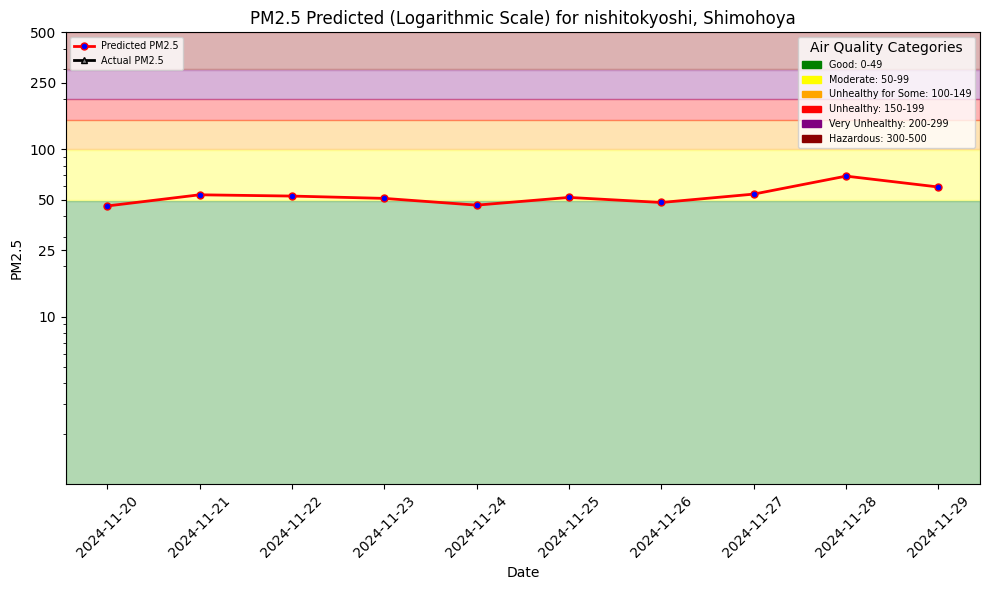

In [124]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---